# Reading Data from Text Files

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Evaluation import compute_clusters, compute_purity, compute_recall, compute_f1, compute_entropy

# Reading Data from Text Files

In [2]:
data_directory = "/home/hussein/PatternDatasets/Activities"
training_data_means = []
evaluation_data_means = []
flattened_training_data = []
flattened_evaluation_data = []
training_labels = []
evaluation_labels = []

# Step 1: Accessing the Data Directory
activities = os.listdir(data_directory)

# Step 2: Iterating Through Activity Folders
for activity in activities:
    activity_path = os.path.join(data_directory, activity)
    activity_number = int(activity.split("a")[1])
    
    print("Activity Number:", activity_number)
    print("Activity:", activity)
    # Assigning labels
    training_labels.extend([activity_number] * 48 * 8) 
    evaluation_labels.extend([activity_number] * 12 * 8)
    
    
    # Step 3: Iterating Through Subject Folders
    subjects = os.listdir(activity_path)
    for subject in subjects:
        subject_path = os.path.join(activity_path, subject)
        
        # Step 4: Reading Text Files (Segments)
        segments = os.listdir(subject_path)
        training_segments = segments[:48]  # First 48 segments for training
        evaluation_segments = segments[48:]  # Rest for evaluation
        
        for segment_file in training_segments:
            segment_file_path = os.path.join(subject_path, segment_file)
            with open(segment_file_path, 'r') as file:
                segment_data = np.loadtxt(file, delimiter=',')
                mean_data = np.mean(segment_data, axis=0)  # Taking mean along columns
                training_data_means.append(mean_data)
                
                flattened_data = segment_data.flatten()  # Flattening the segment
                flattened_training_data.append(flattened_data)
        
        for segment_file in evaluation_segments:
            segment_file_path = os.path.join(subject_path, segment_file)
            with open(segment_file_path, 'r') as file:
                segment_data = np.loadtxt(file, delimiter=',')
                mean_data = np.mean(segment_data, axis=0)  # Taking mean along columns
                evaluation_data_means.append(mean_data)
                
                flattened_data = segment_data.flatten()  # Flattening the segment
                flattened_evaluation_data.append(flattened_data)

# Convert the data lists into numpy arrays
training_data_means = np.array(training_data_means)
evaluation_data_means = np.array(evaluation_data_means)
flattened_training_data = np.array(flattened_training_data)
flattened_evaluation_data = np.array(flattened_evaluation_data)
PCA_reduction=PCA(n_components=0.9)
PCA_training_data = PCA_reduction.fit_transform(flattened_training_data)
PCA_evaluation_data = PCA_reduction.transform(flattened_evaluation_data)

Activity Number: 11
Activity: a11
Activity Number: 13
Activity: a13
Activity Number: 18
Activity: a18
Activity Number: 3
Activity: a03
Activity Number: 5
Activity: a05
Activity Number: 4
Activity: a04
Activity Number: 19
Activity: a19
Activity Number: 6
Activity: a06
Activity Number: 7
Activity: a07
Activity Number: 8
Activity: a08
Activity Number: 2
Activity: a02
Activity Number: 1
Activity: a01
Activity Number: 12
Activity: a12
Activity Number: 15
Activity: a15
Activity Number: 17
Activity: a17
Activity Number: 14
Activity: a14
Activity Number: 16
Activity: a16
Activity Number: 10
Activity: a10
Activity Number: 9
Activity: a09


In [3]:
print("Shape of training labels", np.array(training_labels).shape)
print("Shape of evaluation labels", np.array(evaluation_labels).shape)
print("Shape of training data (means):", training_data_means.shape)
print("Shape of evaluation data (means):", evaluation_data_means.shape)
print("Shape of flattened training data:", flattened_training_data.shape)
print("Shape of flattened evaluation data:", flattened_evaluation_data.shape)
print("Shape of PCA training data:", PCA_training_data.shape)
print("Shape of PCA evaluation data:", PCA_evaluation_data.shape)

Shape of training labels (7296,)
Shape of evaluation labels (1824,)
Shape of training data (means): (7296, 45)
Shape of evaluation data (means): (1824, 45)
Shape of flattened training data: (7296, 5625)
Shape of flattened evaluation data: (1824, 5625)
Shape of PCA training data: (7296, 346)
Shape of PCA evaluation data: (1824, 346)


In [4]:
pd.DataFrame(training_labels)

,0
0,11
1,11
2,11
3,11
4,11
...,...
7291,9
7292,9
7293,9
7294,9


In [5]:
pd.DataFrame(evaluation_labels)

,0
0,11
1,11
2,11
3,11
4,11
...,...
1819,9
1820,9
1821,9
1822,9


In [6]:
pd.DataFrame(training_data_means)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,9.463623,-0.169830,2.998977,0.004409,0.023790,-0.002431,-0.659485,0.142973,-0.565096,-0.731891,...,0.385116,-9.714778,-2.864157,-1.666767,-0.057504,0.156331,0.013497,0.842121,0.642905,-0.155769
1,9.476056,-0.222168,2.838336,-0.001879,0.048451,-0.000265,-0.668427,0.148597,-0.553009,-0.668899,...,0.398193,-9.810123,-2.787432,-1.609051,-0.107312,0.106966,-0.089040,0.876152,0.610063,-0.163081
2,9.207562,-0.219169,2.999778,0.016151,0.015965,0.006579,-0.643951,0.165409,-0.578870,-0.763694,...,0.418826,-9.725551,-2.621162,-1.788985,-0.127252,0.086398,0.111089,0.866224,0.633439,-0.164946
3,9.476754,-0.175272,2.783112,-0.000048,0.038873,-0.008345,-0.670262,0.130099,-0.557054,-0.624340,...,0.388737,-9.907426,-2.714160,-1.500715,-0.103577,0.103234,-0.098368,0.863716,0.613491,-0.157234
4,9.353961,-0.240682,2.776958,-0.007014,-0.005827,-0.009539,-0.675379,0.146718,-0.546130,-0.754283,...,0.400183,-9.504918,-2.738909,-1.634349,-0.062187,0.110814,-0.127982,0.850519,0.646350,-0.164660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,8.569390,-1.816948,4.409214,-0.005117,-0.001691,-0.011827,-1.003295,0.117056,0.074922,8.189152,...,0.106067,-10.445570,-0.627586,-0.430435,-0.041317,0.204751,-0.070301,0.788958,-0.419361,0.095562
7292,8.783426,-1.834095,4.025974,-0.015930,0.029256,-0.020495,-0.992442,0.115806,0.118030,8.342118,...,0.039752,-10.328952,-0.854359,-0.097083,0.101475,0.145063,0.089044,0.792835,-0.404309,0.104835
7293,9.060753,-2.154024,2.909284,0.006749,0.017012,0.000023,-0.629399,0.316977,-0.698595,8.323634,...,0.037144,-10.130082,-0.812957,-0.446078,0.018500,0.170298,-0.020820,0.706226,0.557941,-0.000902
7294,8.669431,-1.762650,4.362763,-0.001790,0.043422,-0.004631,-1.001597,0.123951,0.090320,8.189076,...,0.097354,-10.261746,-0.985279,-0.150991,0.010737,0.156802,0.058141,0.794878,-0.415031,0.079238


In [7]:
pd.DataFrame(evaluation_data_means)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,9.472670,-0.272738,2.725906,0.009250,0.035732,-0.006189,-0.684218,0.145956,-0.547239,-0.472892,...,0.389349,-9.920878,-2.703421,-1.721789,-0.108109,0.113192,-0.119129,0.858603,0.605785,-0.142047
1,9.139147,-0.384357,3.261742,0.013179,0.020691,0.002530,-0.625601,0.172328,-0.603960,-0.739187,...,0.405976,-9.795554,-2.494996,-1.563673,-0.042978,0.093128,-0.160382,0.865180,0.635071,-0.169360
2,9.194726,-0.369558,3.078556,0.004354,-0.006008,-0.013039,-0.647647,0.165743,-0.579657,-0.665781,...,0.407273,-9.766066,-2.496204,-1.713778,-0.058548,0.107597,-0.186254,0.852770,0.634384,-0.159151
3,9.317678,-0.201494,2.763203,0.010133,-0.000088,0.004207,-0.679321,0.138913,-0.549962,-0.377449,...,0.386958,-9.761353,-2.661107,-1.572883,-0.112073,0.134298,0.118636,0.857806,0.615536,-0.161535
4,9.376414,-0.297518,3.034184,-0.002855,0.037688,-0.005732,-0.645982,0.169311,-0.576912,-0.747337,...,0.421722,-9.652412,-2.717035,-1.702552,-0.071277,0.127123,0.088348,0.850481,0.641037,-0.171528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,9.064330,-1.723098,3.267133,0.002562,0.027453,0.011228,-0.612238,0.275970,-0.725037,8.186106,...,0.024452,-10.041501,-0.905619,-0.600707,-0.095827,0.113906,0.086600,0.727792,0.531622,-0.001710
1820,8.606701,-1.757017,4.334498,0.016706,0.008302,0.001027,-0.996843,0.124098,0.089461,8.203506,...,0.102029,-10.198734,-0.592361,-0.387937,-0.078700,0.178007,0.029144,0.780570,-0.428183,0.092244
1821,8.957722,-2.138222,3.285014,-0.030203,0.030316,-0.017804,-0.603521,0.300659,-0.718782,8.229657,...,0.040366,-10.093598,-0.800619,-0.518499,0.050664,0.164849,-0.034196,0.704539,0.557057,0.005829
1822,8.443589,-1.821839,4.678541,-0.001596,0.008604,-0.018738,-1.005183,0.141008,0.055131,8.044452,...,0.108596,-10.190159,-0.774342,-0.275753,-0.003412,0.177233,0.008880,0.790645,-0.424063,0.072930


In [8]:
pd.DataFrame(PCA_training_data)

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,345
0,21.321965,-75.492509,67.883860,-32.360119,20.484552,2.387250,3.156933,-0.547257,-4.005556,-3.333702,...,-3.974110,-3.862068,-3.446593,-2.749031,0.416154,-2.034849,-2.562367,4.268676,1.885579,-1.244694
1,20.482578,-74.162199,69.184385,-34.151067,19.787890,-0.181956,1.471200,0.270675,-2.305080,-3.401502,...,-3.436962,1.704288,1.462103,-0.526579,1.511646,-1.048466,-0.459013,-7.597394,-4.513982,1.069812
2,21.258210,-73.471550,68.076878,-35.758201,25.825449,-2.972525,-0.786571,-0.026821,-0.370764,-0.788266,...,-2.883757,2.559318,1.745072,1.922706,5.652148,4.164296,-5.201447,1.988381,-2.983573,-3.413019
3,19.857928,-74.241022,69.451059,-34.603909,19.977524,1.373702,2.712862,0.906379,-0.497494,-3.448419,...,2.638927,-0.496183,-3.942824,-0.017053,4.768055,-2.488416,-1.271935,-5.649696,-2.601809,2.501392
4,22.972442,-72.860739,69.093035,-35.739325,20.911722,-0.882516,-0.687485,-0.531699,-0.277038,-3.570726,...,1.717175,-4.160378,-2.700974,-0.383368,-6.699713,-4.861057,1.625252,6.281398,-4.786625,-3.156542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7291,-107.485501,23.697962,6.636783,52.246444,-19.342664,1.347518,-0.213338,1.698341,-0.767989,3.784771,...,3.276000,-6.122884,-7.261908,1.023264,0.784551,1.920128,3.392541,-2.853997,0.761542,7.793407
7292,-107.397439,22.587690,1.776285,49.104274,-21.380511,5.594888,2.101889,-0.815471,1.700092,0.968651,...,1.433457,-0.678642,1.079254,0.257777,1.125281,-3.380359,3.449854,3.500964,-8.673513,-4.835229
7293,-106.109538,24.191123,0.608641,37.516404,-26.539447,0.318823,2.243428,-1.229936,1.798028,1.970624,...,5.259197,-1.109290,7.130868,-0.563684,-2.142125,-4.885171,1.303480,-1.598842,3.212735,0.712381
7294,-105.814352,22.751869,3.571967,52.879790,-21.906625,-0.133608,2.489736,1.297855,3.094100,1.786804,...,-2.189987,-1.459191,1.544142,0.967801,-0.771689,-0.444044,-0.890681,-1.296275,-2.429057,-1.878844


In [9]:
pd.DataFrame(PCA_evaluation_data)

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,345
0,18.838961,-74.031786,68.964816,-35.474588,21.264002,1.754540,-2.321176,0.305687,-2.387818,-4.675822,...,-3.222075,-0.742321,-0.123505,-0.101267,-1.485956,-3.456380,3.117218,-3.715603,-6.917683,1.299171
1,21.895216,-71.967620,68.717522,-33.860596,25.563993,0.776144,-2.057305,1.648945,-1.862356,-0.222214,...,-1.246834,5.435562,5.032202,-0.681010,1.485593,1.398300,0.899369,-3.781002,0.104066,5.123470
2,21.857011,-72.762702,68.678503,-35.317226,25.141980,-0.475020,-2.171759,-1.411008,0.333297,-0.996228,...,1.105713,3.750487,-0.516183,2.139861,-1.294764,-5.177102,3.169244,2.389359,0.673908,6.435698
3,18.580557,-72.335365,67.655167,-34.232755,21.608059,1.008291,-2.180074,0.124325,-0.116788,-4.993958,...,0.151525,1.307645,-2.733180,3.128188,3.347765,-0.205901,-2.199912,1.128259,-5.433587,-4.012213
4,22.020201,-73.741688,68.054024,-35.494230,23.423820,0.373778,0.255207,1.110176,-0.673412,-2.071824,...,3.833836,3.781129,-2.879488,-0.676628,1.832338,-0.150588,1.499624,-0.886306,1.786518,-3.008029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,-103.387599,18.312514,0.467069,41.729186,-26.381010,0.474091,-2.539191,1.166307,3.469269,1.842360,...,-0.923470,-1.213742,1.988814,0.096543,-2.855445,-2.279655,-3.175083,3.701039,3.134174,-1.787840
1820,-107.395911,22.844534,6.226328,51.671762,-19.294564,2.896962,-0.164239,0.391396,-0.028703,4.742503,...,-3.357832,-3.923127,-3.051917,-1.214107,8.694513,4.265065,3.709408,1.150345,-3.314822,-2.583572
1821,-103.108532,21.478928,2.100530,40.506931,-25.126465,-0.932269,1.512028,-1.571524,-0.153695,1.390160,...,2.675052,-1.001762,-3.342602,0.950099,0.624038,5.608055,-1.190976,-0.372668,2.181051,1.435549
1822,-104.679037,20.252128,8.990931,55.609968,-19.028386,1.295289,1.050789,2.333130,-1.164837,4.434545,...,-2.820149,4.412009,1.993836,2.571303,-4.891283,-1.690569,0.446988,5.719171,-0.200125,-2.597223


# Kmeans Clustering implementation

In [10]:
class Kmeans:
    def __init__(self, n_clusters, max_iter=300, tol=1e-4):
        self.centroids = None
        self.cluster_centers_ = None
        self.clusters = None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.inertia_ = None
        np.random.seed(42)

    def fit(self, data):
        # Initialize centroids randomly
        clusters = None
        centroids_idx = np.random.choice(data.shape[0], self.n_clusters, replace=False)
        self.centroids = data[centroids_idx]

        for _ in range(self.max_iter):
            # Assignment step
            distances = np.linalg.norm(data[:, None] - self.centroids, axis=2)
            clusters = np.argmin(distances, axis=1)

            # Update step
            new_centroids = np.array([data[clusters == k].mean(axis=0) for k in range(self.n_clusters)])

            # Check convergence
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break

            self.centroids = new_centroids

        self.clusters = clusters
        self.cluster_centers_ = self.centroids

        # Calculate inertia
        self.inertia_ = self._calculate_inertia(data)

    def _calculate_inertia(self, data):
        inertia = 0
        for i in range(self.n_clusters):
            cluster_points = data[self.clusters == i]
            distances = np.linalg.norm(cluster_points - self.centroids[i], axis=1)
            inertia += np.sum(distances**2)
        return inertia

    def predict(self, data):
        distances = np.linalg.norm(data[:, None] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

# Applying Kmeans Clustering on the first approach

In [11]:
Ks = [8, 13, 19, 28, 38]
means_score = []
means_inertia = []
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    means_score.append(metrics.silhouette_score(training_data_means, kmeans.clusters, metric='euclidean'))
    means_inertia.append(kmeans.inertia_)
    print("Silhouette Score:", means_score[-1])
    print("Inertia:", kmeans.inertia_)


Silhouette Score: 0.20582421734077247
Inertia: 406192.0104156245
Silhouette Score: 0.18067801194879612
Inertia: 351771.9702320236
Silhouette Score: 0.2247389440945375
Inertia: 244950.2323166069
Silhouette Score: 0.2421022670539106
Inertia: 212385.666025683
Silhouette Score: 0.2594968500265767
Inertia: 167059.42971826


# Applying Kmeans Clustering on the second approach

In [12]:
reduce_score = []
reduce_inertia = []
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    reduce_score.append(metrics.silhouette_score(PCA_training_data, kmeans.clusters, metric='euclidean'))
    reduce_inertia.append(kmeans.inertia_)
    print("Silhouette Score:", reduce_score[-1])
    print("Inertia:", kmeans.inertia_)

Silhouette Score: 0.14723999657977765
Inertia: 185800661.96200022
Silhouette Score: 0.11088765376983699
Inertia: 171617136.6831025
Silhouette Score: 0.08864941242367827
Inertia: 156171003.20622104
Silhouette Score: 0.07207736818220811
Inertia: 148413133.60446167
Silhouette Score: 0.0816261061301823
Inertia: 138076591.48617598


# Plotting the results

## Silhouette Score vs Number of Clusters

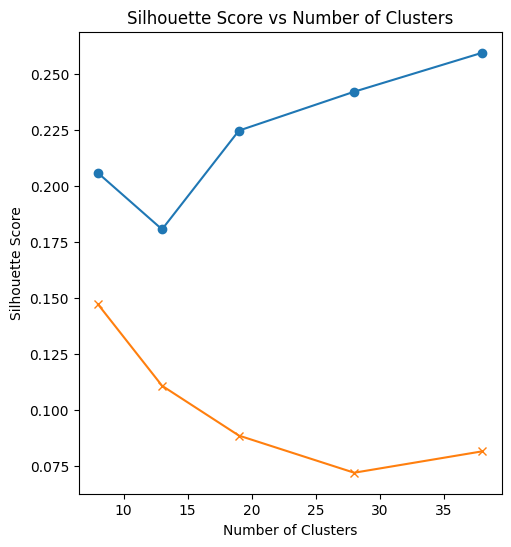

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(Ks, means_score, marker='o', label='Mean Data')
plt.plot(Ks, reduce_score, marker='x', label='PCA Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

From the plot, we see that the silhouette score is higher for the mean data compared to the PCA data. This indicates that the mean data is more suitable for clustering compared to the PCA data. The silhouette score is highest for 38 clusters in mean data case while the highest for 8 clusters in the PCA data case.

## Inertia vs Number of Clusters

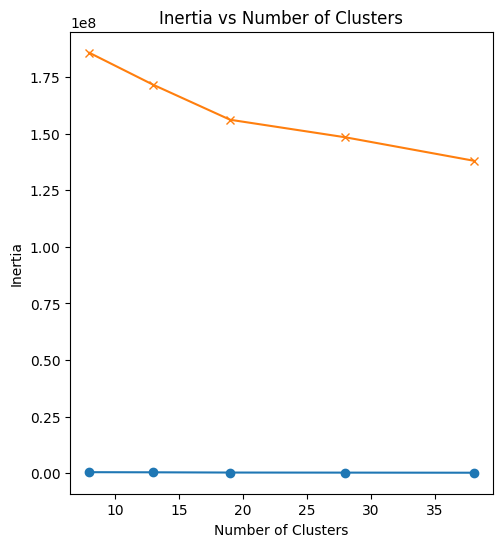

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(Ks, means_inertia, marker='o', label='Mean Data')
plt.plot(Ks, reduce_inertia, marker='x', label='PCA Data')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.show()

From the plot, we see that the inertia is higher for the PCA data compared to the mean data. This indicates that the mean data is more suitable for clustering compared to the PCA data. The inertia is highest for eight clusters in both cases.

# Conclusion

We observed that the mean data is more suitable for clustering compared to the PCA data because of the following:
1- The silhouette score is higher for the mean data compared to the PCA data.
2- The inertia is lower for the mean data compared to the PCA data.

# Evaluation

## Purity

In [15]:
# Means approach
print("Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    test_clusters=kmeans.predict(evaluation_data_means)
    print(f'Training data=> # clusters = {K}:', compute_purity(compute_clusters(training_labels, kmeans.clusters, K), len(training_data_means)))
    print(f'Evaluation data=> # clusters = {K}:', compute_purity(compute_clusters(evaluation_labels, test_clusters, K), len(evaluation_data_means)))

# PCA approach
print("PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    test_clusters=kmeans.predict(PCA_evaluation_data)
    print(f'Training data=> # clusters = {K}:', compute_purity(compute_clusters(training_labels, kmeans.clusters, K), len(PCA_training_data)))
    print(f'Evaluation data=> # clusters = {K}:', compute_purity(compute_clusters(evaluation_labels, test_clusters, K), len(PCA_evaluation_data)))

Means approach
Training data=> # clusters = 8: 0.2727521929824561
Evaluation data=> # clusters = 8: 0.27631578947368424
Training data=> # clusters = 13: 0.3789747807017544
Evaluation data=> # clusters = 13: 0.3848684210526316
Training data=> # clusters = 19: 0.5038377192982456
Evaluation data=> # clusters = 19: 0.5032894736842105
Training data=> # clusters = 28: 0.5105537280701754
Evaluation data=> # clusters = 28: 0.5137061403508771
Training data=> # clusters = 38: 0.5548245614035088
Evaluation data=> # clusters = 38: 0.5520833333333334
PCA approach
Training data=> # clusters = 8: 0.27617872807017546
Evaluation data=> # clusters = 8: 0.2730263157894737
Training data=> # clusters = 13: 0.36992872807017546
Evaluation data=> # clusters = 13: 0.36622807017543857
Training data=> # clusters = 19: 0.4594298245614035
Evaluation data=> # clusters = 19: 0.4583333333333333
Training data=> # clusters = 28: 0.5134320175438597
Evaluation data=> # clusters = 28: 0.5164473684210527
Training data=> # 

## Recall

In [16]:
# Means approach
print("Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    test_clusters=kmeans.predict(evaluation_data_means)
    print(f'Training data=> # clusters = {K}:', compute_recall(compute_clusters(training_labels, kmeans.clusters, K), len(training_data_means)))
    print(f'Evaluation data=> # clusters = {K}:', compute_recall(compute_clusters(evaluation_labels, test_clusters, K), len(evaluation_data_means)))

# PCA approach
print("PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    test_clusters=kmeans.predict(PCA_evaluation_data)
    print(f'Training data=> # clusters = {K}:', compute_recall(compute_clusters(training_labels, kmeans.clusters, K), len(PCA_training_data)))
    print(f'Evaluation data=> # clusters = {K}:', compute_recall(compute_clusters(evaluation_labels, test_clusters, K), len(PCA_evaluation_data)))

Means approach
Training data=> # clusters = 8: 0.7319621482090644
Evaluation data=> # clusters = 8: 0.7413537097953217
Training data=> # clusters = 13: 0.6359834726790936
Evaluation data=> # clusters = 13: 0.6467813413742689
Training data=> # clusters = 19: 0.576749388934576
Evaluation data=> # clusters = 19: 0.5792614674707601
Training data=> # clusters = 28: 0.4110849837810672
Evaluation data=> # clusters = 28: 0.41575292397660824
Training data=> # clusters = 38: 0.3431599934895833
Evaluation data=> # clusters = 38: 0.3418996710526316
PCA approach
Training data=> # clusters = 8: 0.8906960292169226
Evaluation data=> # clusters = 8: 0.899802403143275
Training data=> # clusters = 13: 0.8145480685763888
Evaluation data=> # clusters = 13: 0.8240131578947368
Training data=> # clusters = 19: 0.6189357467562135
Evaluation data=> # clusters = 19: 0.6287063687865497
Training data=> # clusters = 28: 0.47578974495157167
Evaluation data=> # clusters = 28: 0.48726471125730997
Training data=> # clu

## F1 Score

In [17]:
# Means approach
print("Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    test_clusters=kmeans.predict(evaluation_data_means)
    print(f'Training data=> # clusters = {K}:', compute_f1(compute_clusters(training_labels, kmeans.clusters, K)))
    print(f'Evaluation data=> # clusters = {K}:', compute_f1(compute_clusters(evaluation_labels, test_clusters, K)))

# PCA approach
print("PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    test_clusters=kmeans.predict(PCA_evaluation_data)
    print(f'Training data=> # clusters = {K}:', compute_f1(compute_clusters(training_labels, kmeans.clusters, K)))
    print(f'Evaluation data=> # clusters = {K}:', compute_f1(compute_clusters(evaluation_labels, test_clusters, K)))

Means approach
Training data=> # clusters = 8: 0.40217652619900757
Evaluation data=> # clusters = 8: 0.4063353448530108
Training data=> # clusters = 13: 0.46537381601534344
Evaluation data=> # clusters = 13: 0.4725303892171923
Training data=> # clusters = 19: 0.4845980791345595
Evaluation data=> # clusters = 19: 0.4831586761581224
Training data=> # clusters = 28: 0.3956348284437177
Evaluation data=> # clusters = 28: 0.39658143284489217
Training data=> # clusters = 38: 0.3551220090578746
Evaluation data=> # clusters = 38: 0.35274205420936405
PCA approach
Training data=> # clusters = 8: 0.4196539093214403
Evaluation data=> # clusters = 8: 0.4066210690246757
Training data=> # clusters = 13: 0.4130608284909204
Evaluation data=> # clusters = 13: 0.3991374624194114
Training data=> # clusters = 19: 0.4351679332574515
Evaluation data=> # clusters = 19: 0.4299235552461598
Training data=> # clusters = 28: 0.3873366788242488
Evaluation data=> # clusters = 28: 0.38688309972451923
Training data=> #

## Conditional Entropy

In [18]:
# Means approach
print("Means approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(training_data_means)
    test_clusters=kmeans.predict(evaluation_data_means)
    print(f'Training data=> # clusters = {K}:', compute_entropy(compute_clusters(training_labels, kmeans.clusters, K), len(training_data_means)))
    print(f'Evaluation data=> # clusters = {K}:', compute_entropy(compute_clusters(evaluation_labels, test_clusters, K), len(evaluation_data_means)))

# PCA approach
print("PCA approach")
for K in Ks:
    kmeans = Kmeans(n_clusters=K)
    kmeans.fit(PCA_training_data)
    test_clusters=kmeans.predict(PCA_evaluation_data)
    print(f'Training data=> # clusters = {K}:', compute_entropy(compute_clusters(training_labels, kmeans.clusters, K), len(PCA_training_data)))
    print(f'Evaluation data=> # clusters = {K}:', compute_entropy(compute_clusters(evaluation_labels, test_clusters, K), len(PCA_evaluation_data)))

Means approach
Training data=> # clusters = 8: 2.59547454176182
Evaluation data=> # clusters = 8: 2.5863561795649685
Training data=> # clusters = 13: 2.212211616375981
Evaluation data=> # clusters = 13: 2.200867321329525
Training data=> # clusters = 19: 1.8293647137976
Evaluation data=> # clusters = 19: 1.8347378110345454
Training data=> # clusters = 28: 1.6481767657662678
Evaluation data=> # clusters = 28: 1.655388497206718
Training data=> # clusters = 38: 1.5141782273402418
Evaluation data=> # clusters = 38: 1.5175758464592073
PCA approach
Training data=> # clusters = 8: 2.637557550902777
Evaluation data=> # clusters = 8: 2.6459859389017386
Training data=> # clusters = 13: 2.3547528173673404
Evaluation data=> # clusters = 13: 2.3648411197607144
Training data=> # clusters = 19: 2.032922768619152
Evaluation data=> # clusters = 19: 2.0285032560545893
Training data=> # clusters = 28: 1.8059219833614781
Evaluation data=> # clusters = 28: 1.7975271556310757
Training data=> # clusters = 38: